In [163]:
import pandas as pd
import json
from pprint import pprint
import os
import sys
from timeit import default_timer as timer
from read_json import get_author_institution, get_study_author
from read_pdf import pdf2text
import re
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

%matplotlib inline 



if sys.platform == "linux":
    studies_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/home/wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"
else:    
    studies_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"



# Reading authors database
with open(os.path.join(authors_path)) as file:
    authors = json.load(file)

# Reading studies database
with open(os.path.join(studies_path)) as file:
    studies = json.load(file)
    

### Authors statsistics

|                                         |     |
|-----------------------------------------|-----|
| # of authors                            | 126 |
| # of authors affiliated with CB         | 19  |
| # of authors affiliated with university | 97  |
| # of authors affiliated with private    | 13  |
| # of authors affiliated with government | 12  |

In [164]:
authors_institutions = get_author_institution(authors)
studies_authors = get_study_author(studies)

# Number of unique authors (126)
authors_institutions['author'].nunique()

#Number of authors affiliated with university (97)
sum(authors_institutions['university'])

# Number of authors affiliated with central bank (19)
sum(authors_institutions['central bank'])

# Number of authors affiliated with governmental institutions (13)
sum(authors_institutions['governmental'])

# Number of authors affiliated with governmental institutions (12)
sum(authors_institutions['private'])

12

In [165]:
def read_txt_studies(studies_location):
    """
    Reads all of the .txt files from given location
    
    Returns:
    - list of all texts
    """
    
    # Get .txt files from the directory
    study_files = [file for file in os.listdir(studies_location) if '.txt' in file]

    # Remove extensions
    study_labels = [x.split('.')[0] for x in study_files]

    # Create file paths from files and their location
    study_paths = [studies_location + x for x in study_files]


    studies = []
    for text in study_paths:

        with open(text, 'r') as file:
            studies.append(file.read().replace('\n', ''))

    df_studies = pd.DataFrame()
    df_studies['text'] = studies
    df_studies['label'] = study_labels
    return df_studies

test_data = read_txt_studies(studies_location)

In [166]:
# Cleaning texts

from clean_txt import clean_string

test_data['text'] = test_data['text'].apply(lambda x: clean_string(x))

## Uncertainty index 

In [167]:
def uncertainty_index(documents, labels):
    
    uncertainty_keys = ['possibility', 'may', 'might', 'could', 'unsettled', 'inconceivable', 'plausibly', 'hopeful',
                    'unpredictably', 'rare', 'probability', 'hypothetical', 'vague', 'unbelievable', 'assumable', 
                    'credible', 'unsure', 'doubtful', 'assumed', 'incredible', 'undecided', 'dubious', 'likely', 
                    'indeterminate', 'unclear', 'unlikely', 'maybe', 'obtainable', 'questionable', 'impossible', 
                    'feasibly', 'thinkable', 'precarious', 'possible', 'imaginably', 'uncertain', 'hesitant',
                    'questionable', 'presumptuously', 'uncertainty', 'ambivalent', 'unconvincing', 'potential', 
                    'uncertainties', 'ambiguous', 'unimaginable', 'imaginable', 'undetermined', 'possibly', 
                    'perhaps', 'conceivable', 'unpredictable', 'conceivably', 'presumably', 'probable', 
                    'unconfirmed', 'implausible', 'seemingly', 'dependent', 'probably', 'improbable', 'believably',
                    'depends', 'potentially', 'speculative', 'seem']
    
    uncertainty_score = []
    for document, label in zip(documents, labels):
        keys_count = [document.count(key) for key in uncertainty_keys]
        uncertainty_score.append((label, sum(keys_count)/len(document)))

    return uncertainty_score

uncertainty_index(test_data['text'], test_data['label'])

[('p042', 0.0006435665286899033),
 ('p070', 0.0007746219107340465),
 ('p013', 0.0005748517487595304),
 ('p060', 0.0005972556104698909),
 ('p036', 0.0006115299605999983),
 ('p010', 0.0006692665096464471),
 ('p006', 0.0),
 ('p040', 0.0004555005363151476),
 ('p041', 8.666512595331639e-05),
 ('p038', 0.0008340043713332566),
 ('p046', 0.00033323336332433606),
 ('p050', 0.0),
 ('p056', 0.0007514987756480621),
 ('p018', 0.0005624629958555358),
 ('p025', 0.0008157736766765688),
 ('p003', 0.0017096290105047204),
 ('p005', 0.0006640373470701867),
 ('p071', 0.0008282992730959828),
 ('p007', 0.0007432265039075697),
 ('p009', 0.00040109096743141346),
 ('p049', 0.0007132667617689016),
 ('p067', 0.00044147673969427735),
 ('p053', 0.000674594251398791),
 ('p062', 0.000704327096727588),
 ('p015', 0.0006075669704501519),
 ('p034', 0.0006487187804086928),
 ('p004', 0.0007107713448583591),
 ('p026', 0.0007919398125742444),
 ('p023', 0.00043855277583972887),
 ('p063', 0.0008456449286176192),
 ('p069', 0.00

## LSA: Clustering

In [147]:
 
# With removed words that occure in more than half of texts
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english',
                             use_idf=True)

# Without removed words that occure in more than half of texts
vectorizer = TfidfVectorizer(max_features=1000,
                             min_df=2, stop_words='english',
                             use_idf=True)

X_tfidf = vectorizer.fit_transform(test_data['text'])

feature_names = vectorizer.get_feature_names()



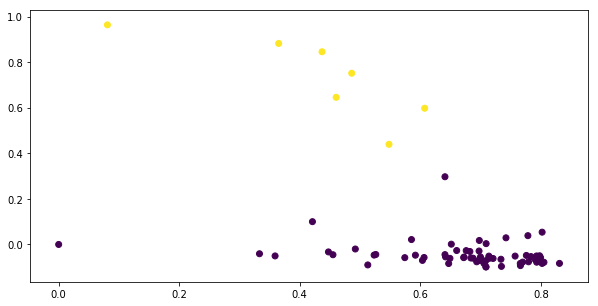

In [157]:
kmeans = KMeans(n_clusters=2).fit(X_tfidf)

svd = TruncatedSVD(n_components=2)

svd_data = svd.fit_transform(X_tfidf)
plt.figure(figsize=(10, 5))
plt.scatter(svd_data[:,0], svd_data[:,1], c = kmeans.labels_)
plt.show() 

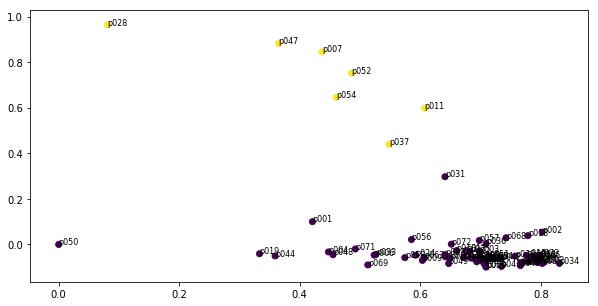

In [162]:
# Get .txt files from the directory
study_files = [file for file in os.listdir(studies_location) if '.txt' in file]

# Remove extensions
study_labels = [x.split('.')[0] for x in study_files]

# Set up plot
plt.figure(figsize=(10, 5))
plt.scatter(svd_data[:,0], svd_data[:,1], c = kmeans.labels_)

# Add labels
for i in range(len(svd_data)):
    plt.text(svd_data[i][0], svd_data[i][1], study_labels[i], size=8)

plt.show() 


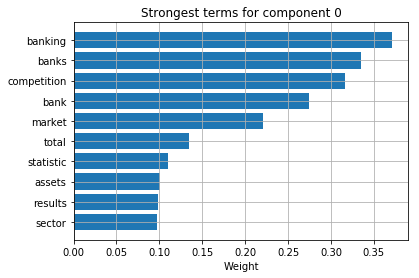

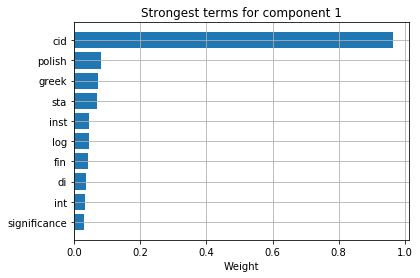

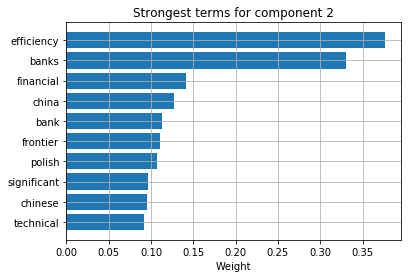

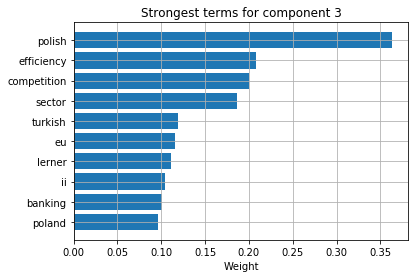

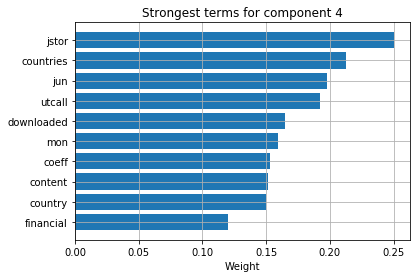

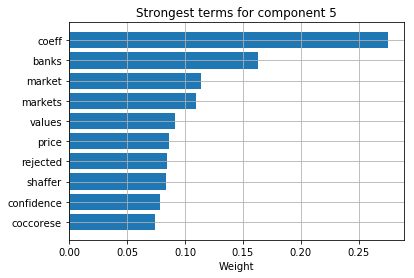

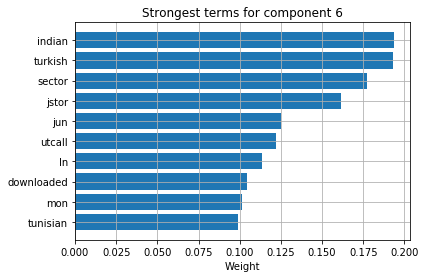

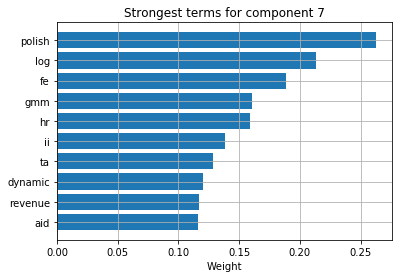

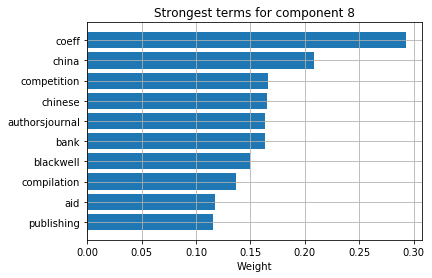

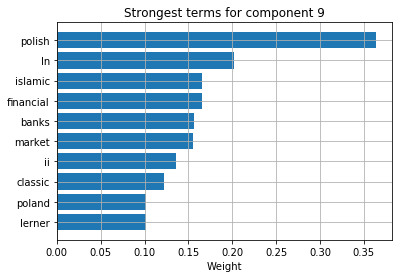

In [42]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_tfidf = lsa.fit_transform(X_tfidf)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

#for compNum in range(0, 100, 10):
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feature_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(10) + .5    # the bar centers on the y axis
    
    plt.figure(compNum)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum))
    plt.grid(True)
    
plt.show()